In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_blobs
from matplotlib.widgets import Slider
import logging

# Suppress warnings
logging.getLogger("matplotlib").setLevel(logging.ERROR)

In [4]:
def my_softmax(z):
  ez = np.exp(z)
  sm = ez / np.sum(ez)
  return sm

In [5]:
# make  dataset for example
centers = [[-5, 2], [-2, -2], [1, 2], [5, -2]]
X_train, y_train = make_blobs(n_samples=2000, centers=centers, cluster_std=1.0,random_state=30)

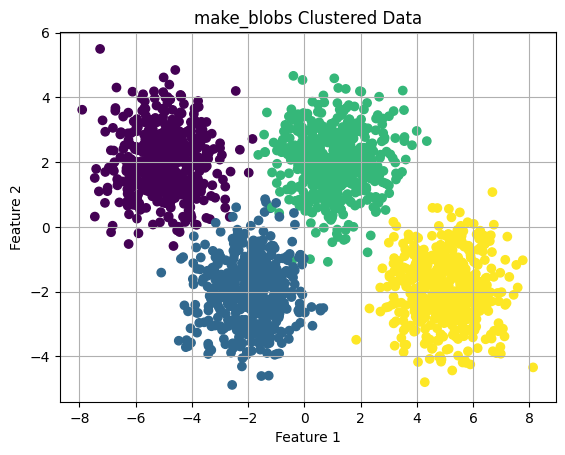

In [6]:
import matplotlib.pyplot as plt

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis')
plt.title("make_blobs Clustered Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

**The Obvious organization**
The model below is implemented with the softmax as an activation in the final Dense layer. The loss function is separately specified in the compile directive.

The loss function is SparseCategoricalCrossentropy. This loss is described in (3) above. In this model, the softmax takes place in the last layer. The loss function takes in the softmax output which is a vector of probabilities.

In [7]:
X_train = torch.tensor(X_train , dtype= torch.float32) # [2000,2]
y_train = torch.tensor(y_train , dtype= torch.int64) # [2000,]

In [9]:
# === Define Model ===

model = nn.Sequential(
    nn.Linear(2, 25),        # Input layer (2 features) → 25 neurons
    nn.ReLU(),               # Activation
    nn.Linear(25, 15),       # Hidden layer → 15 neurons
    nn.ReLU(),               # Activation
    nn.Linear(15, 4)         # Output layer → 4 classes
    # Note: No Softmax here! CrossEntropyLoss does it for you.
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
epochs = 10
for epoch in range(epochs):
  model.train()
  outputs = model(X_train)                  # Forward pass
  loss = criterion(outputs, y_train)        # Compute loss
  optimizer.zero_grad()                     # Clear previous gradients
  loss.backward()                           # Backpropagation
  optimizer.step()                          # Update weights
  print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/10, Loss: 1.4024
Epoch 2/10, Loss: 1.3832
Epoch 3/10, Loss: 1.3642
Epoch 4/10, Loss: 1.3456
Epoch 5/10, Loss: 1.3272
Epoch 6/10, Loss: 1.3090
Epoch 7/10, Loss: 1.2912
Epoch 8/10, Loss: 1.2736
Epoch 9/10, Loss: 1.2563
Epoch 10/10, Loss: 1.2393


In [12]:
# Ensure the model is in evaluation mode
model.eval()

# Disable gradient tracking (important for inference)
with torch.no_grad():
    p_nonpreferred = model(X_train)            # raw logits
    p_nonpreferred = torch.softmax(p_nonpreferred, dim=1)  # apply softmax for probabilities

# Convert to NumPy for printing
p_np = p_nonpreferred.numpy()

# Print results
print(p_np[:2])
print("largest value", np.max(p_np), "smallest value", np.min(p_np))

[[0.18927205 0.25665998 0.33652228 0.21754564]
 [0.46616217 0.25275773 0.06127216 0.2198079 ]]
largest value 0.655184 smallest value 0.018363262


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [14]:
prefered_model = Sequential(
    [
      Dense(25,activation='relu'),
      Dense(15,activation='relu'),
      Dense(4,activation='linear')
    ]
)
prefered_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)
prefered_model.fit(
    X_train,
    y_train,
    epochs=10,
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3328
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6012
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3048
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1465
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0973
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0740
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0660
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0533
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0477
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0414


In [16]:
p_preferred = prefered_model.predict(X_train)
print(f"two example output vectors:\n {p_preferred[:2]}")
print("largest value", np.max(p_preferred), "smallest value", np.min(p_preferred))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
two example output vectors:
 [[-3.0076714 -1.8374047  3.1761434 -1.4704721]
 [ 5.5248957  0.8920519 -4.4206505 -7.7216516]]
largest value 9.214591 smallest value -18.8372


In [17]:
sm_preferred = tf.nn.softmax(p_preferred).numpy()
print(f"two example output vectors:\n {sm_preferred[:2]}")
print("largest value", np.max(sm_preferred), "smallest value", np.min(sm_preferred))

two example output vectors:
 [[2.0254704e-03 6.5277941e-03 9.8202521e-01 9.4215674e-03]
 [9.9031794e-01 9.6328780e-03 4.7476515e-05 1.7493313e-06]]
largest value 0.99999636 smallest value 2.4173299e-11


In [18]:
for i in range(5):
    print( f"{p_preferred[i]}, category: {np.argmax(p_preferred[i])}")

[-3.0076714 -1.8374047  3.1761434 -1.4704721], category: 2
[ 5.5248957  0.8920519 -4.4206505 -7.7216516], category: 0
[ 4.0639253   0.88824874 -3.5810604  -6.1072125 ], category: 0
[-2.1998823  2.5324185 -3.738822  -2.0906487], category: 1
[-1.2077649 -3.9473956  5.299981  -5.2835836], category: 2
